## Table of Contents
* [1. Downloading data](#1)
* [2. Model Fitting & Evaluation](#models)
    * [3.1. Linear Regression](#3_linreg)
    * [3.2. Ridge](#3_ridge)
    * [3.3. Lasso](#3_lasso)
    * [3.4. k-Nearest Neighbors](#3_knn)
    * [3.5. Decision Tree](#3_tree)
    * [3.6. Random Forest](#3_forest)
    * [3.7. Ensemble Method](#3_ensemble)
        * [3.7.1. Voting Regressor](#3_voting)
        * [3.7.2. Bagging Regressor](#3_bagging)
        * [3.7.3. AdaBoost Regressor](#3_adaboost)
        * [3.7.4. Gradient Boosting Regressor](#3_gradient)
        * [3.7.5. XGBoost](#3_xgboost)
        * [3.7.6. Stacked Ensembles](#3_stacked)
* [3. MLflow](#mlflow)
* [4. Conclusion](#4)
* [5. Predicting a price by example features](#5)

In [27]:
import pandas as pd
import numpy as np
import time
import itertools

# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib import cm

# import geopandas as gpd
# import geopy.distance

<a id="1"></a>

# 1. Downloading data

In [3]:
price_df4 = pd.read_csv("poland_apartments_completed.csv")
price_df4.head()

,Unnamed: 0,id,city,floor,latitude,longitude,price,rooms,sq,year,latitude_center,longitude_center,decade,price_per_m,sq_round,radius,radius_dec,radius_ceil,district
0,0,23918.0,Kraków,2,50.049224,19.970379,749000,3,74,2021,50.061389,19.937222,2020,10121,70,2.732975,2.7,3,Dzielnica XIII Podgórze
1,1,17828.0,Warszawa,3,52.249775,21.106886,240548,1,24,2021,52.230000,21.011111,2020,10022,20,6.902500,6.9,7,Praga Południe
2,2,22784.0,Kraków,2,50.066964,19.920025,427000,2,37,1970,50.061389,19.937222,1970,11540,30,1.378660,1.4,2,Dzielnica V Krowodrza
3,3,4315.0,Poznañ,2,52.404212,16.882542,1290000,5,166,1935,52.408333,16.933611,1930,7771,160,3.505600,3.5,4,Grunwald
4,4,11770.0,Warszawa,1,52.212225,20.972630,996000,5,105,2020,52.230000,21.011111,2020,9485,100,3.290526,3.3,4,Ochota


In [7]:
cat_features = ['city', 'district'] # 'floor', 'rooms'?
num_features = ['floor', 'rooms', 'sq', 'year', 'radius']
target = ['price']


<a id="models"></a>

# 2. Model Fitting & Evaluation

In [78]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

from sklearn.metrics import mean_squared_error
from sklearn.metrics import *

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PowerTransformer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
# import xgboost as xgb

import mlflow
import mlflow.sklearn

# import pickle
# from mlflow import log_metric, log_param, log_artifact
from mlflow.models.signature import infer_signature


In [5]:
def to_split_and_scale(df, cat_features, num_features, target):
    X = df[cat_features + num_features]
    y = df[target]

    # encoding the categorical variables into numerical variables
    labels_dict = {}
    le = LabelEncoder()
    for col in cat_features:
        X[col] = le.fit_transform(X[col])
        labels_dict[col] = dict(zip(le.classes_, range(len(le.classes_))))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    st_scaler = StandardScaler()
    X_train_scaled = st_scaler.fit_transform(X_train)
    X_test_scaled = st_scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, st_scaler

In [8]:
# for full dataset: 3 cities with districts - 64- %
X_train_scaled, X_test_scaled, y_train, y_test, st_scaler = to_split_and_scale(price_df4, cat_features, num_features, target)

# for Ochota district of Warsaw - ~90%
# price_df4_Warsaw_Ochota = price_df4[price_df4['district'] == 'Ochota']
# X_train_scaled, X_test_scaled, y_train, y_test, st_scaler = to_split_and_scale(price_df4_Warsaw_Ochota, cat_features, num_features, target)

# for Śródmieście district of Warsaw - 75-83%
# price_df4_Warsaw_Srodiemescie = price_df4[price_df4['district'] == 'Śródmieście']
# X_train_scaled, X_test_scaled, y_train, y_test, st_scaler = to_split_and_scale(price_df4_Warsaw_Srodiemescie, cat_features, num_features, target)



/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_26917/1191976145.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


In [9]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [10]:
def reg_model_implementation(model, grid, X_train, y_train, X_test, y_test):
    '''
    This function:
    - fits and returns regression model with GridSearchCV;
    - prints confusion matrix and classification report.
    '''
    
    start_time = time.time()
    mod = model()
    mod_cv = GridSearchCV(mod, grid, cv=10)
    mod_cv.fit(X_train, y_train)
    
    print("Model: {0}".format(namestr(model, globals())[0]))
    if grid != {}:
        print("Tuned hyperparameters:") # , mod_cv.best_params_
        for k, v in mod_cv.best_params_.items():
            print("\t{0}: {1}".format(k, v))
    print()

    mod = model(**mod_cv.best_params_)
    mod.fit(X_train, y_train)
    y_pred_mod = mod.predict(X_test)

    print("R2-score:  ", mod.score(X_test, y_test))
    print("RMSE:      ", mean_squared_error(y_test, y_pred_mod, squared=False))
    print()
    print("Time using clf_model_implementation(): {0:.4f} sec".format(time.time() - start_time))
    
    return mod

In [11]:
def show_feature_importances(model, col_names): # list(X_train) !!!!!!! 
    '''
    This function plots the feature importances for given model.
    '''
    resultdict = {}
    importance = model.feature_importances_

    print("score:\t  feature:")
    for i in range(len(col_names)):
        resultdict[col_names[i]] = importance[i]
    
    resultdict = dict(sorted(resultdict.items(), key=lambda item: -item[1]))
    for k, v in resultdict.items():
        print("{1:.3f}\t- {0}".format(k, v))

    plt.bar(resultdict.keys(),resultdict.values())
    plt.xticks(rotation='vertical')
    plt.title('Feature Importance')
    plt.show()
    
    return 1

<a id="3_linreg"></a>

## 3.1. Linear Regression

In [16]:
linreg = reg_model_implementation(LinearRegression, {}, X_train_scaled, y_train, X_test_scaled, y_test)

Model: LinearRegression

R2-score:   0.6456541217381851
RMSE:       335535.75144777086

Time using clf_model_implementation(): 0.1679 sec


<a id="3_ridge"></a>

## 3.2. Ridge

In [534]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# GridSearchCV(ridge, grid, cv=kf)
grid = {
    "alpha": np.logspace(-4, 5, 10),
    "solver": ["sag", "lsqr"]
}

ridge = reg_model_implementation(Ridge, grid, X_train_scaled, y_train, X_test_scaled, y_test)

Model: Ridge
Tuned hyperparameters:
	alpha: 100.0
	solver: lsqr

R2-score:   0.6443024610501176
RMSE:       336175.0968370143

Time using clf_model_implementation(): 2.2347 sec


<a id="3_lasso"></a>

## 3.3. Lasso

In [535]:
grid = {
    "alpha": np.logspace(-4, 5, 10),
    "max_iter": [1000]
}

lasso = reg_model_implementation(Lasso, grid, X_train_scaled, y_train, X_test_scaled, y_test)

Model: Lasso
Tuned hyperparameters:
	alpha: 1000.0
	max_iter: 1000

R2-score:   0.645012570639768
RMSE:       335839.3615593049

Time using clf_model_implementation(): 29.0306 sec


<a id="3_knn"></a>

## 3.4. k-Nearest Neighbors

In [536]:
grid = {
    "n_neighbors": range(4, 10, 1),
    "leaf_size": range(20, 40, 5),
    "p": range(2, 5, 1),
    "algorithm": ['auto', 'ball_tree'] # ‘kd_tree’, ‘brute’
}

knn = reg_model_implementation(KNeighborsRegressor, grid, X_train_scaled, y_train, X_test_scaled, y_test)

Model: KNeighborsRegressor
Tuned hyperparameters:
	algorithm: auto
	leaf_size: 30
	n_neighbors: 9
	p: 2

R2-score:   0.7752411203771884
RMSE:       267228.97000866674

Time using clf_model_implementation(): 434.8763 sec


<a id="3_tree"></a>

## 3.5. Decision Tree

In [537]:
grid = {
    "min_samples_split": range(10, 30, 2),
    "max_depth": range(4, 10, 2),
#     "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    "splitter": ['best', 'random']
}

tree = reg_model_implementation(DecisionTreeRegressor, grid, X_train_scaled, y_train, X_test_scaled, y_test)

Model: DecisionTreeRegressor
Tuned hyperparameters:
	max_depth: 8
	min_samples_split: 18
	splitter: best

R2-score:   0.7744780307588892
RMSE:       267682.22654279147

Time using clf_model_implementation(): 5.4922 sec


<a id="3_forest"></a>

## 3.6. Random Forest

In [539]:
grid = {
    "n_estimators": [200, 300], # range(100, 400, 100)
    "max_depth": [8, 10], # range(4, 10, 2)
    "min_samples_split": [20, 30], # range(20, 40, 10)
    "n_jobs": [-1],
    "random_state": [42]
}

forest = reg_model_implementation(RandomForestRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())

# .values.ravel() - only for RandomForest because of https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected


Model: RandomForestRegressor
Tuned hyperparameters:
	max_depth: 10
	min_samples_split: 20
	n_estimators: 300
	n_jobs: -1
	random_state: 42

R2-score:   0.8303499723268795
RMSE:       232167.84801937971

Time using clf_model_implementation(): 52.7816 sec


<a id="3_ensemble"></a>

## 3.7. Ensemble Methods

<a id="3_voting"></a>

### 3.7.1. Voting Regressor

In [159]:
def reg_voting_by_weights(weights_list): 
    reg_voting = VotingRegressor(
        estimators=[
            ('linreg', linreg),
            ('ridge', ridge),
            ('tree', tree),
            ('forest', forest)
        ],
        weights=weights_list
    )

    reg_voting.fit(X_train_scaled, y_train)
    y_pred_reg_voting = reg_voting.predict(X_test_scaled)

    # R-squared, RMSE
#     print(reg_voting.score(X_test_scaled, y_test))
#     print(mean_squared_error(y_test, y_pred_reg_voting, squared=False))
    return reg_voting.score(X_test_scaled, y_test), mean_squared_error(y_test, y_pred_reg_voting, squared=False)

# weights = [0, 0, 0, 4]
# weights = [1, 1, 3, 4]
# reg_voting_by_weights(weights)

In [355]:
from itertools import product

rrange = [1,2,3]
max_score = 0
weights_for_max = []

for p in product(rrange, repeat=4):
    weights = list(p)
    print(weights)
    score, mse = reg_voting_by_weights(weights)
    if score > max_score:
        max_score = score
        weights_for_max = weights
print()
print(max_score)
print(weights_for_max)

[1, 1, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



0.806729441144687
[1, 1, 3, 3]


<a id="3_bagging"></a>

### 3.7.2. Bagging Regressor

In [356]:
# for linreg

bag_reg = BaggingRegressor(
    estimator=linreg, 
    n_estimators=40, 
    max_features=7, 
    max_samples=0.5, 
    bootstrap=True, # oob_score=True,
    random_state=42
)
# , bootstrap=True

bag_reg.fit(X_train_scaled, y_train)
y_pred_bag_reg = bag_reg.predict(X_test_scaled)

print(bag_reg.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_bag_reg, squared=False))


0.6452611033502875
335721.77756306174


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:510: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


In [357]:
# for ridge

bag_reg = BaggingRegressor(
    estimator=ridge, 
    n_estimators=10, 
    max_features=7, 
    max_samples=0.3, 
    bootstrap=True, # oob_score=True,
    random_state=42
)
# , bootstrap=True

bag_reg.fit(X_train_scaled, y_train)
y_pred_bag_reg = bag_reg.predict(X_test_scaled)

print(bag_reg.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_bag_reg, squared=False))


0.6483371008180494
334263.0599853332


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:510: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


<a id="3_adaboost"></a>

### 3.7.3. AdaBoost Regressor

In [541]:
# for linreg:

grid = {
    "estimator": [linreg],
    "n_estimators": [60],
    "learning_rate": [0.01],
    "loss": ['linear'],
    "random_state": [42]
}

reg_ada_linreg = reg_model_implementation(AdaBoostRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())


Model: AdaBoostRegressor
Tuned hyperparameters:
	estimator: LinearRegression()
	learning_rate: 0.01
	loss: linear
	n_estimators: 60
	random_state: 42

R2-score:   0.6482317873391715
RMSE:       334313.1075886529

Time using clf_model_implementation(): 35.7458 sec


In [542]:
# for reg_xgb:

grid = {
    "estimator": [reg_xgb],
    "n_estimators": [60],
    "learning_rate": [0.01],
    "loss": ['linear'],
    "random_state": [42]
}

reg_ada_xgb = reg_model_implementation(AdaBoostRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())


KeyboardInterrupt: 

<a id="3_gradient"></a>

### 3.7.4. Gradient Boosting Regressor

In [543]:
grid = {
    "n_estimators": [300],
    "learning_rate": [0.1],
    "random_state": [42]
}

clf_gb = reg_model_implementation(GradientBoostingRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())


Model: GradientBoostingRegressor
Tuned hyperparameters:
	learning_rate: 0.1
	n_estimators: 300
	random_state: 42

R2-score:   0.8453910688985511
RMSE:       221637.06850568793

Time using clf_model_implementation(): 39.0604 sec


<a id="3_xgboost"></a>

### 3.7.5. XGBoost

In [548]:
grid = {
    "n_estimators": [200, 300], # range(100, 400, 100)
    "max_depth": range(4, 10, 2),
    "learning_rate": [0.1, 0.2, 0.3],
    "n_jobs": [-1],
    "objective": ['reg:squarederror'],
    "random_state": [42]
}

reg_xgb = reg_model_implementation(XGBRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())


Model: XGBRegressor
Tuned hyperparameters:
	learning_rate: 0.2
	max_depth: 6
	n_estimators: 200
	n_jobs: -1
	objective: reg:squarederror
	random_state: 42

R2-score:   0.8582016430842119
RMSE:       212256.35781101728

Time using clf_model_implementation(): 291.0094 sec


In [475]:
reg_xgb = XGBRegressor(max_depth=8, learning_rate=0.2, n_estimators=200, n_jobs=2, objective='reg:squarederror', random_state=42)
reg_xgb.fit(X_train_scaled, y_train)
y_pred_reg_xgb = reg_xgb.predict(X_test_scaled)

print(reg_xgb.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_reg_xgb, squared=False))


0.873548997031265
200440.85549336098


**Why the result for best parameters isn't the best?**

Hyperparameter tuning is performed on the validation (development) set, not on the training set.

Grid Search Cross-Validation is using the K-Fold strategy to build a validation set that is used only for validation, not for training.

More details: https://stackoverflow.com/questions/64256966/grid-search-not-giving-the-best-parameters

feature: city,	 score: 0.11265
feature: district,	 score: 0.12594
feature: floor,	 score: 0.05862
feature: rooms,	 score: 0.04583
feature: sq,	 score: 0.48116
feature: year,	 score: 0.07549
feature: radius,	 score: 0.10030


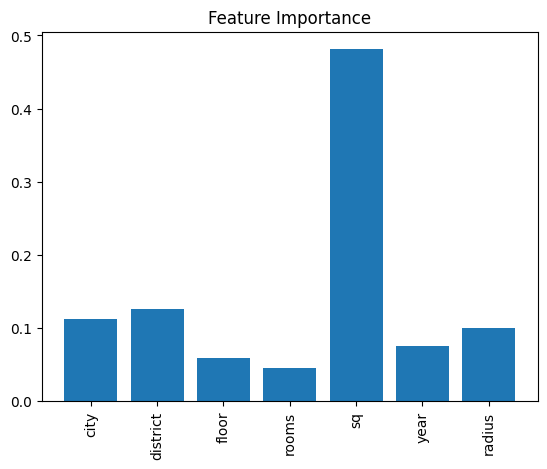

1

In [480]:
show_feature_importances(reg_xgb)

In [315]:
import catboost as cb
# couldn't install 

ModuleNotFoundError: No module named 'catboost'

In [ ]:
# reg_cat = cb.CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=500)
# reg_cat.fit(X_train_scaled, y_train)
# y_pred_reg_cat = reg_cat.predict(X_test_scaled)

# print(reg_cat.score(X_test_scaled, y_test))
# print(mean_squared_error(y_test, y_pred_reg_cat, squared=False))


In [235]:
import lightgbm as lgb
# try to install !!

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
# reg_lgb = lgb.LGBMRegressor(max_depth = 3, learning_rate = 0.1, n_estimators = 100, objective='mean_squared_error', seed=500)
# reg_lgb.fit(X_train_scaled, y_train)
# y_pred_reg_lgb = reg_lgb.predict(X_test_scaled)

# print(reg_lgb.score(X_test_scaled, y_test))
# print(mean_squared_error(y_test, y_pred_reg_lgb, squared=False))



<a id="3_stacked"></a>

### 3.7.6. Stacked Ensembles

In [361]:
# from sklearn.ensemble

from sklearn.ensemble import StackingRegressor

# Prepare the list of tuples with the first-layer classifiers
regressors = [
    ('linreg', linreg),
    ('ridge', ridge),
    ('tree', tree),
    ('forest', forest)
]
# Instantiate the second-layer meta estimator
reg_meta = LinearRegression()

reg_stack = StackingRegressor(
    estimators=regressors,
    final_estimator=reg_meta,
#     stack_method='predict_proba',
    passthrough = False
)

reg_stack.fit(X_train_scaled, y_train)
y_pred_reg_stack = reg_stack.predict(X_test_scaled)

print(reg_stack.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_reg_stack, squared=False))


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_stacking.py:956: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8328325911212718
230462.84239565092


In [362]:
# from mlxtend.regressor

from mlxtend.regressor import StackingRegressor

reg_meta2 = LinearRegression()

reg_stack2 = StackingRegressor(
    regressors=[linreg, ridge, tree, forest],   
    meta_regressor=reg_meta2,   
    use_features_in_secondary=False
)

reg_stack2.fit(X_train_scaled, y_train)
y_pred_reg_stack2 = reg_stack2.predict(X_test_scaled)

print(reg_stack.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_reg_stack2, squared=False))


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8328325911212718
232848.43173794213


<a id="mlflow"></a>

# 3. MLflow

In [19]:
all_regressors = {'linreg': LinearRegression(),
                   'ridge': Ridge(), # alpha=100, solver="lsqr"
                   'lasso': Lasso(), # alpha=1000, max_iter=1000
                   'knn': KNeighborsRegressor(), # algorithm="auto", leaf_size=30, n_neighbors=9, p=2
                   'tree': DecisionTreeRegressor() # max_depth=8, min_samples_split=18, splitter="best"
                   }


In [48]:
# param_grid = [{'vect__ngram_range': [(1, 1)],
#                'vect__stop_words': [stop, None]}]

param_grid = [{
    "reg__alpha": np.logspace(-4, 5, 10),
    "reg__solver": ["sag", "lsqr"],
    "reg__max_iter": [1000],
    "reg__n_neighbors": range(4, 10, 1),
    "reg__leaf_size": range(20, 40, 5),
    "reg__p": range(2, 5, 1),
#     "reg__algorithm": ['auto', 'ball_tree'], # 'copy_X', 'fit_intercept', 'n_jobs', 'positive'
    "reg__min_samples_split": range(10, 30, 2),
    "reg__max_depth": range(4, 10, 2),
    "reg__splitter": ['best', 'random']
}]

# {
#     "alpha": np.logspace(-4, 5, 10),
#     "solver": ["sag", "lsqr"],
#     "max_iter": [1000],
#     "n_neighbors": range(4, 10, 1),
#     "leaf_size": range(20, 40, 5),
#     "p": range(2, 5, 1),
#     "algorithm": ['auto', 'ball_tree'], # 'memory', 'steps', 'verbose'
#     "min_samples_split": range(10, 30, 2),
#     "max_depth": range(4, 10, 2),
# # #     "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
#     "splitter": ['best', 'random']
# }
# grid = {
#     "alpha": np.logspace(-4, 5, 10),
#     "solver": ["sag", "lsqr"]
# }

# grid = {
#     "alpha": np.logspace(-4, 5, 10),
#     "max_iter": [1000]
# }
# grid = {
#     "n_neighbors": range(4, 10, 1),
#     "leaf_size": range(20, 40, 5),
#     "p": range(2, 5, 1),
#     "algorithm": ['auto', 'ball_tree'] # ‘kd_tree’, ‘brute’
# }
# grid = {
#     "min_samples_split": range(10, 30, 2),
#     "max_depth": range(4, 10, 2),
# #     "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
#     "splitter": ['best', 'random']
# }

grids = {
    'linreg': {},
    'ridge': {
        "alpha": np.logspace(-4, 5, 10),
        "solver": ["sag", "lsqr"]
    },
    'lasso': {
        "alpha": np.logspace(-4, 5, 10),
        "max_iter": [1000]
    },
    'knn': {
        "n_neighbors": range(8, 11, 1),
        "leaf_size": range(25, 40, 5),
        "p": [2],
        "algorithm": ['auto']
    },
    'tree': {
        "min_samples_split": range(10, 30, 2),
        "max_depth": range(4, 10, 2),
    #     "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        "splitter": ['best', 'random']
    }
}

In [49]:
best_models = {}
rmse_dict = {}

for reg_name, reg in all_regressors.items():
    with mlflow.start_run():
        # assert run.info.experiment_id == EXP_ID
        print("{0}:".format(reg_name))
#         tfidf_clf_pipe = Pipeline([('vect', tfidf), ('clf', clf)])
#         tfidf_reg_pipe = Pipeline([('reg', reg)])
#         tfidf_reg_pipe_gs = GridSearchCV(tfidf_reg_pipe,
#                                          param_grid=param_grid,
#                                          scoring='accuracy',
#                                          verbose=0,
#                                          cv=3,
#                                          n_jobs=-1)
#         tfidf_reg_pipe_gs.fit(X_train_scaled, y_train)
#         best_model = tfidf_reg_pipe_gs.best_estimator_
        mod = reg
        mod_cv = GridSearchCV(mod, grids[reg_name], cv=10)
        mod_cv.fit(X_train_scaled, y_train)
        best_model = mod_cv.best_estimator_
        best_models[reg] = best_model
        y_pred_mod = best_model.predict(X_test_scaled)
        rmse = mean_squared_error(y_test, y_pred_mod, squared=False)
        rmse_dict[reg_name] = rmse
        print("R2-score:  ", mod_cv.score(X_test_scaled, y_test)) # mod ?!
        print("RMSE:      ", mean_squared_error(y_test, y_pred_mod, squared=False))
        print()
        
#         print("Model: {0}".format(namestr(model, globals())[0]))
#         if grid != {}:
#             print("Tuned hyperparameters:") # , mod_cv.best_params_
#             for k, v in mod_cv.best_params_.items():
#                 print("\t{0}: {1}".format(k, v))
#         print()

#         mod = model(**mod_cv.best_params_)
#         mod.fit(X_train, y_train)
#         y_pred_mod = mod.predict(X_test)


linreg:
R2-score:   0.6456541217381851
RMSE:       335535.75144777086

ridge:
R2-score:   0.6443054360653513
RMSE:       336173.6909682409

lasso:
R2-score:   0.645012570639768
RMSE:       335839.3615593049

knn:
R2-score:   0.7752411203771884
RMSE:       267228.97000866674

tree:
R2-score:   0.7780986787323083
RMSE:       265524.7768710357



In [57]:


def eval_metrics(actual, pred):
    rmse = mean_squared_error(actual, pred, squared=False)
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return (rmse, mae, r2)


def main(X_train_scaled, y_train, X_test_scaled, y_test, max_depth, ntrees, lr):
    xgbRegressor = XGBRegressor(
        max_depth=max_depth,
        n_estimators=ntrees,
        learning_rate=lr,
        random_state=42,
        seed=42,
        subsample=0.75,
        colsample_bytree=0.75,
        reg_lambda=1,
        gamma=1)
    pipeline = Pipeline(steps=[("regressor", xgbRegressor)])

    pipeline.fit(X_train_scaled, y_train)
    y_pred = pipeline.predict(X_test_scaled)
    
    (rmse, mae, r2) = eval_metrics(y_test, y_pred)
    
    print("XGBoost tree model (max_depth=%f, trees=%f, lr=%f):" % (max_depth, ntrees, lr))
    print("\tRMSE: %s" % rmse)
    print("\tMAE: %s" % mae)
    print("\tR2: %s" % r2)
    
    with mlflow.start_run() as run:
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("ntrees", ntrees)
        mlflow.log_param("lr", lr)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("MAE", mae)

        mlflow.sklearn.log_model(pipeline, "model")
        
    #print("Model saved in run %s" % mlflow.active_run_id())


In [58]:
if __name__ == "__main__":
    main(X_train_scaled, y_train, X_test_scaled, y_test, 8, 200, 0.2)
#     main()


XGBoost tree model (max_depth=8.000000, trees=200.000000, lr=0.200000):
	RMSE: 202742.94596518882
	MAE: 77704.32219503012
	R2: 0.8706277031725675


In [ ]:
# /Users/user/Documents/GitHub/poland-apartment-prices/mlruns

# OTHER VERSION of MLflow

In [80]:
def model_feature_importance(model):
    feature_importance = pd.DataFrame(
        model.feature_importances_,
        index=X_train_scaled, # X_train_scaled.columns
        columns=["Importance"],
    )

    # sort by importance
    feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=feature_importance.reset_index(),
        y="index",
        x="Importance",
    ).set_title("Feature Importance")
    # save image
    plt.savefig("model_artifacts/feature_importance.png", bbox_inches='tight')


In [61]:
def model_permutation_importance(model):
    p_importance = permutation_importance(model, X_test_scaled, y_test, random_state=42, n_jobs=-1)

    # sort by importance
    sorted_idx = p_importance.importances_mean.argsort()[::-1]
    p_importance = pd.DataFrame(
        data=p_importance.importances[sorted_idx].T,
        columns=X_train.columns[sorted_idx]
    )

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=p_importance,
        orient="h"
    ).set_title("Permutation Importance")

    # save image
    plt.savefig("model_artifacts/permutation_importance.png", bbox_inches="tight")

In [101]:
def rmsle_cv_score(model, X_train, y_train):
    kf = KFold(n_splits=3, shuffle=True, random_state=42).get_n_splits(X_train)
    return np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))


In [176]:
# Track params and metrics
def log_mlflow_run(model, signature, parameters, metrics):
    # Auto-logging for scikit-learn estimators
    # mlflow.sklearn.autolog()

    # log estimator_name name
    mlflow.set_tag("estimator_name", model.__class__.__name__)

    # log input features
#     mlflow.set_tag("features", str(X_train_scaled.tolist())) # X_train_scaled.columns.values.tolist()

    # Log tracked parameters only
    mlflow.log_params({key: model.get_params()[key] for key in parameters})

    mlflow.log_metrics(metrics)

    # log training loss (ONLY FOR GradientBoostingRegressor ???)
#     for s in model.train_score_:
#         mlflow.log_metric("Train Loss", s)

    # Save model to artifacts
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # log charts
#     mlflow.log_artifacts("model_artifacts")

In [103]:
# generate parameters combinations
def parameter_product(parameters):
    params_values = [parameters[key] if isinstance(parameters[key], list) else [parameters[key]] for key in parameters.keys()]
    return [dict(zip(parameters.keys(), combination)) for combination in itertools.product(*params_values)]


In [177]:
# training loop
def training_loop(model_class, parameters, X_train_scaled, y_train, X_test_scaled, y_test):
    runs_parameters = parameter_product(parameters)
    model_params = {}
    
    for i, run_parameters in enumerate(runs_parameters):
        print(f"Run {i}: {run_parameters}")

        if mlflow.active_run():
            mlflow.end_run()

        # mlflow: track run
        with mlflow.start_run(run_name=f"Run {i}"):

            model = model_class(**run_parameters)
            model.fit(X_train_scaled, y_train)

            # get evaluations scores
            score = mean_squared_error(y_test, model.predict(X_test_scaled), squared=False)
            print("RMSE score: {:.4f}".format(score))
            score_cv = rmsle_cv_score(model, X_train_scaled, y_train)
            print("Cross-Validation RMSE score: {:.4f} (std = {:.4f})".format(score_cv.mean(), score_cv.std()))
            r2 = r2_score(y_test, model.predict(X_test_scaled)) # NEW
            print("R2-score: {:.4f}".format(r2))

            # generate charts
        #     model_feature_importance(model)
        #     plt.close()
        #     model_permutation_importance(model)
        #     plt.close()
        #     model_tree_visualization(model)

            # get model signature
            signature = infer_signature(model_input=X_train_scaled, model_output=model.predict(X_train_scaled))
            # mlflow: log metrics
            metrics = {
                'RMSE': score,
                'RMSE_CV': score_cv.mean(),
                'R2': r2,
            }
            log_mlflow_run(model, signature, parameters, metrics)

        print("")
        
        model_params[f"Run {i}"] = {
            'params': run_parameters,
            'RMSE': score,
            'RMSE_CV': score_cv,
            'R2': r2
        }

    return model_params

In [143]:
# Initialize MLflow experiment

experiment_name = "poland_apartments"

mlflow.set_experiment(experiment_name)
mlflow.set_tracking_uri("./mlruns")

# delete default experiment if exits
# if (mlflow.get_experiment_by_name("Default").lifecycle_stage == 'active'):
#     mlflow.delete_experiment("0")

# create model_artifacts directory 
# !mkdir -p "model_artifacts"

In [142]:
# # MLflow UI URL

# # create remote tunnel using ngrok.com to allow local port access
# # !pip install pyngrok --quiet
# from pyngrok import ngrok

# # Terminate open tunnels if exist
# ngrok.kill()

# # Setting the authtoken (optional)
# # Get your authtoken from https://dashboard.ngrok.com/auth
# NGROK_AUTH_TOKEN = ""
# ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# # Open an HTTPs tunnel on port 5000 for http://localhost:5000
# public_url = ngrok.connect(port="5000", proto="http", options={"bind_tls": True})
# print("MLflow Tracking UI:", public_url)

In [144]:
# Start experiments tracking UI

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

[2023-06-02 18:48:57 +0400] [46599] [INFO] Starting gunicorn 20.1.0
[2023-06-02 18:48:57 +0400] [46599] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-06-02 18:48:57 +0400] [46599] [ERROR] Retrying in 1 second.
[2023-06-02 18:48:58 +0400] [46599] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-06-02 18:48:58 +0400] [46599] [ERROR] Retrying in 1 second.
[2023-06-02 18:48:59 +0400] [46599] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-06-02 18:48:59 +0400] [46599] [ERROR] Retrying in 1 second.
[2023-06-02 18:49:00 +0400] [46599] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-06-02 18:49:00 +0400] [46599] [ERROR] Retrying in 1 second.
[2023-06-02 18:49:01 +0400] [46599] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-06-02 18:49:01 +0400] [46599] [ERROR] Retrying in 1 second.
[2023-06-02 18:49:02 +0400] [46599] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.
[2023-06-02 18:49:56 +0400] [4657

In [146]:
all_regressors_clear = {
    'linreg': LinearRegression,
    'ridge': Ridge,
    'lasso': Lasso,
    'knn': KNeighborsRegressor,
    'tree': DecisionTreeRegressor,
    'gbr': GradientBoostingRegressor,
    'xgb': XGBRegressor
}

In [147]:
grids_clear = {
    'linreg': {},
    'ridge': {
        "alpha": list(np.logspace(-4, 5, 10)), 
        "solver": ["sag", "lsqr"]
    },
    'lasso': {
        "alpha": list(np.logspace(-4, 5, 10)),
        "max_iter": [1000]
    },
    'knn': {
        "n_neighbors": [8, 9, 10],
        "leaf_size": [25, 30, 35],
        "p": [2],
        "algorithm": ['auto']
    },
    'tree': {
        "min_samples_split": [10, 15, 20, 25],
        "max_depth": [4, 6, 8],
    #     "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        "splitter": ['best', 'random']
    },
    'gbr': {
        "learning_rate": [0.2, 0.1, 0.05, 0.01],
        "max_depth": [5, 6, 7, 8]
    },
    'xgb': {
        "max_depth": [6, 7, 8, 9],
        "n_estimators": [200, 300],
        "learning_rate": [0.2, 0.1, 0.05, 0.01]
    }
}

In [178]:
full_model_params = {}

for reg, model_class in all_regressors_clear.items():
    print(f"{reg}:".upper())
    full_model_params[reg] = training_loop(model_class, grids_clear[reg], X_train_scaled, y_train, X_test_scaled, y_test)
    print()
    
full_model_params

LINREG:
Run 0: {}
RMSE score: 335535.7514
Cross-Validation RMSE score: 344900.3582 (std = 14761.6406)
R2-score: 0.6457


RIDGE:
Run 0: {'alpha': 0.0001, 'solver': 'sag'}
RMSE score: 335534.9185
Cross-Validation RMSE score: 344901.0624 (std = 14762.0226)
R2-score: 0.6457

Run 1: {'alpha': 0.0001, 'solver': 'lsqr'}
RMSE score: 335535.7520
Cross-Validation RMSE score: 344900.3581 (std = 14761.6410)
R2-score: 0.6457

Run 2: {'alpha': 0.001, 'solver': 'sag'}
RMSE score: 335540.7613
Cross-Validation RMSE score: 344900.9382 (std = 14761.1319)
R2-score: 0.6456

Run 3: {'alpha': 0.001, 'solver': 'lsqr'}
RMSE score: 335535.7574
Cross-Validation RMSE score: 344900.3572 (std = 14761.6451)
R2-score: 0.6457

Run 4: {'alpha': 0.01, 'solver': 'sag'}
RMSE score: 335534.2382
Cross-Validation RMSE score: 344901.2209 (std = 14761.0076)
R2-score: 0.6457

Run 5: {'alpha': 0.01, 'solver': 'lsqr'}
RMSE score: 335535.8112
Cross-Validation RMSE score: 344900.3480 (std = 14761.6857)
R2-score: 0.6457

Run 6: {'al


Run 13: {'min_samples_split': 20, 'max_depth': 4, 'splitter': 'random'}
RMSE score: 395852.9277
Cross-Validation RMSE score: 398000.0756 (std = 26656.7722)
R2-score: 0.5068

Run 14: {'min_samples_split': 20, 'max_depth': 6, 'splitter': 'best'}
RMSE score: 280596.4202
Cross-Validation RMSE score: 302906.2626 (std = 14819.2723)
R2-score: 0.7522

Run 15: {'min_samples_split': 20, 'max_depth': 6, 'splitter': 'random'}
RMSE score: 359197.0031
Cross-Validation RMSE score: 338860.2371 (std = 34213.6335)
R2-score: 0.5939

Run 16: {'min_samples_split': 20, 'max_depth': 8, 'splitter': 'best'}
RMSE score: 268186.7403
Cross-Validation RMSE score: 295612.8605 (std = 9490.1487)
R2-score: 0.7736

Run 17: {'min_samples_split': 20, 'max_depth': 8, 'splitter': 'random'}
RMSE score: 296337.5156
Cross-Validation RMSE score: 335107.4406 (std = 27023.4459)
R2-score: 0.7236

Run 18: {'min_samples_split': 25, 'max_depth': 4, 'splitter': 'best'}
RMSE score: 319510.2680
Cross-Validation RMSE score: 334808.1609

/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 204544.6029


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 224813.9914 (std = 12576.7837)
R2-score: 0.8683

Run 1: {'learning_rate': 0.2, 'max_depth': 6}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 210298.9050


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 238414.1083 (std = 6224.6938)
R2-score: 0.8608

Run 2: {'learning_rate': 0.2, 'max_depth': 7}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 212840.1111


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 250526.6981 (std = 5459.5962)
R2-score: 0.8574

Run 3: {'learning_rate': 0.2, 'max_depth': 8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 223697.6414


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 250460.8315 (std = 15917.4759)
R2-score: 0.8425

Run 4: {'learning_rate': 0.1, 'max_depth': 5}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 221817.0400


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 226833.4263 (std = 14348.2116)
R2-score: 0.8451

Run 5: {'learning_rate': 0.1, 'max_depth': 6}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 215647.0056


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 227561.3585 (std = 16742.2447)
R2-score: 0.8536

Run 6: {'learning_rate': 0.1, 'max_depth': 7}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 220537.7832


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 246426.1252 (std = 10244.0726)
R2-score: 0.8469

Run 7: {'learning_rate': 0.1, 'max_depth': 8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 223877.3539


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 242711.8982 (std = 14102.5203)
R2-score: 0.8422

Run 8: {'learning_rate': 0.05, 'max_depth': 5}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 227058.2697


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 227794.8407 (std = 13506.6734)
R2-score: 0.8377

Run 9: {'learning_rate': 0.05, 'max_depth': 6}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 219302.2473


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 232778.4312 (std = 14126.1235)
R2-score: 0.8486

Run 10: {'learning_rate': 0.05, 'max_depth': 7}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 223058.4913


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 244896.3603 (std = 13040.6009)
R2-score: 0.8434

Run 11: {'learning_rate': 0.05, 'max_depth': 8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 231085.7478


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 250917.7017 (std = 14311.2783)
R2-score: 0.8319

Run 12: {'learning_rate': 0.01, 'max_depth': 5}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 330294.5536


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 327359.5756 (std = 18372.7095)
R2-score: 0.6566

Run 13: {'learning_rate': 0.01, 'max_depth': 6}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 319383.1102


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 316063.6738 (std = 17958.0910)
R2-score: 0.6789

Run 14: {'learning_rate': 0.01, 'max_depth': 7}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 309956.5138


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 314914.7926 (std = 16415.4971)
R2-score: 0.6976

Run 15: {'learning_rate': 0.01, 'max_depth': 8}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 309935.5232


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 312423.8856 (std = 21690.7225)
R2-score: 0.6977


XGB:
Run 0: {'max_depth': 6, 'n_estimators': 200, 'learning_rate': 0.2}
RMSE score: 212256.3578
Cross-Validation RMSE score: 232530.2635 (std = 5328.6154)
R2-score: 0.8582

Run 1: {'max_depth': 6, 'n_estimators': 200, 'learning_rate': 0.1}
RMSE score: 210145.6486
Cross-Validation RMSE score: 225562.2824 (std = 4548.9271)
R2-score: 0.8610

Run 2: {'max_depth': 6, 'n_estimators': 200, 'learning_rate': 0.05}
RMSE score: 209065.4235
Cross-Validation RMSE score: 229205.0242 (std = 5604.2835)
R2-score: 0.8624

Run 3: {'max_depth': 6, 'n_estimators': 200, 'learning_rate': 0.01}
RMSE score: 270512.0254
Cross-Validation RMSE score: 279067.7746 (std = 13208.7833)
R2-score: 0.7697

Run 4: {'max_depth': 6, 'n_estimators': 300, 'learning_rate': 0.2}
RMSE score: 210361.6696
Cross-Validation RMSE score: 232834.8636 (std = 5811.9381)
R2-score: 0.8607

Run 5: {'max_depth': 6, 'n_estimators': 300, 'learning_rate': 0.1}
RMSE s

{'linreg': {'Run 0': {'params': {},
   'RMSE': 335535.75144777086,
   'RMSE_CV': array([330171.37815972, 365077.02633777, 339452.6700836 ]),
   'R2': 0.6456541217381851}},
 'ridge': {'Run 0': {'params': {'alpha': 0.0001, 'solver': 'sag'},
   'RMSE': 335534.9185201899,
   'RMSE_CV': array([330171.20239579, 365078.07203502, 339453.91269481]),
   'R2': 0.645655880978967},
  'Run 1': {'params': {'alpha': 0.0001, 'solver': 'lsqr'},
   'RMSE': 335535.7520452922,
   'RMSE_CV': array([330171.37679149, 365077.02655687, 339452.67092642]),
   'R2': 0.6456541204761485},
  'Run 2': {'params': {'alpha': 0.001, 'solver': 'sag'},
   'RMSE': 335540.7612567367,
   'RMSE_CV': array([330172.05157072, 365076.76105794, 339454.00187273]),
   'R2': 0.6456435403416999},
  'Run 3': {'params': {'alpha': 0.001, 'solver': 'lsqr'},
   'RMSE': 335535.7574229882,
   'RMSE_CV': array([330171.36447746, 365077.02852881, 339452.6785118 ]),
   'R2': 0.6456541091178092},
  'Run 4': {'params': {'alpha': 0.01, 'solver': 'sag

In [179]:
df = mlflow.search_runs(order_by=['artifact_uri'])
df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Train Loss,metrics.RMSE,metrics.RMSE_CV,metrics.R2,...,params.n_neighbors,params.p,params.algorithm,tags.estimator_name,tags.mlflow.log-model.history,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.runName,tags.mlflow.user
0,00ea5f2d1be0456d86a3ce67f60bdde6,755873683349248208,FINISHED,file:///Users/user/Documents/GitHub/poland-apa...,2023-06-01 19:53:38.181000+00:00,2023-06-01 19:53:45.177000+00:00,1.022842e+11,345302.179906,338959.806808,NaN,...,None,None,None,GradientBoostingRegressor,"[{""run_id"": ""00ea5f2d1be0456d86a3ce67f60bdde6""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,Run 6,user
1,017db84e4178479086bc469f5e4ab2d8,755873683349248208,FINISHED,file:///Users/user/Documents/GitHub/poland-apa...,2023-06-02 16:15:14.830000+00:00,2023-06-02 16:15:16.376000+00:00,NaN,277802.969339,291963.092794,0.757102,...,None,None,None,DecisionTreeRegressor,"[{""run_id"": ""017db84e4178479086bc469f5e4ab2d8""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,Run 2,user
2,01a442d7e1b0476fb23fb4a808baa040,755873683349248208,FINISHED,file:///Users/user/Documents/GitHub/poland-apa...,2023-06-02 13:13:49.284000+00:00,2023-06-02 13:13:50.806000+00:00,NaN,310420.957329,312790.556795,0.696714,...,None,None,None,Ridge,"[{""run_id"": ""01a442d7e1b0476fb23fb4a808baa040""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,Run 4,user
3,01aab76a5ae1423d833fe48f9659f492,755873683349248208,FINISHED,file:///Users/user/Documents/GitHub/poland-apa...,2023-06-02 13:12:30.385000+00:00,2023-06-02 13:12:31.865000+00:00,NaN,310420.957329,312790.556795,0.696714,...,None,None,None,DecisionTreeRegressor,"[{""run_id"": ""01aab76a5ae1423d833fe48f9659f492""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,Run 23,user
4,01b86427b7584327b6ac72bf534a219e,755873683349248208,FINISHED,file:///Users/user/Documents/GitHub/poland-apa...,2023-06-02 15:11:37.335000+00:00,2023-06-02 15:11:38.839000+00:00,NaN,310420.957329,312790.556795,0.696714,...,None,None,None,Ridge,"[{""run_id"": ""01b86427b7584327b6ac72bf534a219e""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,Run 16,user
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,fe044041cc6141048ffd94900facd59c,755873683349248208,FINISHED,file:///Users/user/Documents/GitHub/poland-apa...,2023-06-02 13:15:19.157000+00:00,2023-06-02 13:15:20.631000+00:00,NaN,310420.957329,312790.556795,0.696714,...,None,None,None,DecisionTreeRegressor,"[{""run_id"": ""fe044041cc6141048ffd94900facd59c""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,Run 15,user
396,fe2df33ba4994ea19de0f4165a7bed99,755873683349248208,FINISHED,file:///Users/user/Documents/GitHub/poland-apa...,2023-06-02 13:13:55.316000+00:00,2023-06-02 13:13:56.878000+00:00,NaN,310420.957329,312790.556795,0.696714,...,None,None,None,Ridge,"[{""run_id"": ""fe2df33ba4994ea19de0f4165a7bed99""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,Run 8,user
397,fee1089dc33c41deac9bf9cc6f6abbaf,755873683349248208,FINISHED,file:///Users/user/Documents/GitHub/poland-apa...,2023-06-02 16:15:13.342000+00:00,2023-06-02 16:15:14.827000+00:00,NaN,434255.279079,375986.777845,0.406474,...,None,None,None,DecisionTreeRegressor,"[{""run_id"": ""fee1089dc33c41deac9bf9cc6f6abbaf""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,Run 1,user
398,ff910eca63bf4f9fa24b4f944f252425,755873683349248208,FINISHED,file:///Users/user/Documents/GitHub/poland-apa...,2023-06-01 19:27:57.603000+00:00,2023-06-01 19:28:07.052000+00:00,1.431846e+10,213724.979800,

In [167]:
df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.Train Loss', 'metrics.RMSE', 'metrics.RMSE_CV',
       'metrics.R2', 'params.max_depth', 'params.learning_rate',
       'params.solver', 'params.alpha', 'params.splitter',
       'params.min_samples_split', 'params.max_iter', 'params.n_estimators',
       'params.leaf_size', 'params.n_neighbors', 'params.p',
       'params.algorithm', 'tags.estimator_name',
       'tags.mlflow.log-model.history', 'tags.mlflow.source.name',
       'tags.mlflow.source.type', 'tags.mlflow.source.git.commit',
       'tags.mlflow.runName', 'tags.mlflow.user'],
      dtype='object')

In [181]:
df[['start_time', 'metrics.R2', 'tags.estimator_name']].sort_values(['start_time'], ascending=False)[0:40]

,start_time,metrics.R2,tags.estimator_name
40,2023-06-02 16:21:45.794000+00:00,0.834431,XGBRegressor
208,2023-06-02 16:21:37.485000+00:00,0.865489,XGBRegressor
30,2023-06-02 16:21:28.838000+00:00,0.861817,XGBRegressor
13,2023-06-02 16:21:19.468000+00:00,0.866034,XGBRegressor
168,2023-06-02 16:21:12.022000+00:00,0.775941,XGBRegressor
173,2023-06-02 16:21:04.630000+00:00,0.863829,XGBRegressor
216,2023-06-02 16:20:57.978000+00:00,0.861749,XGBRegressor
388,2023-06-02 16:20:51.656000+00:00,0.865707,XGBRegressor
366,2023-06-02 16:20:42.940000+00:00,0.837147,XGBRegressor
32,2023-06-02 16:20:34.686000+00:00,0.863290,XGBRegressor


In [185]:
best_run_df = mlflow.search_runs(order_by=['metrics.R2 DESC'], max_results=1) # 'metrics.RMSE_CV'
if len(best_run_df.index) == 0:
    raise Exception(f"Found no runs for experiment '{experiment_name}'")

best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
best_model = mlflow.sklearn.load_model(best_model_uri)

# print best run info
print("Best run info:")

print(f"Run parameters: {best_run.data.tags['estimator_name']}")
print(f"Run parameters: {best_run.data.params}")
print("Run score: R2 = {:.4f}".format(best_run.data.metrics['R2'])) # RMSE_CV (x2)

print(f"Run id: {best_run.info.run_id}")
print(f"Run model URI: {best_model_uri}")

Best run info:
Run parameters: XGBRegressor
Run parameters: {'max_depth': '8', 'learning_rate': '0.2', 'n_estimators': '300'}
Run score: R2 = 0.8741
Run id: 0a28f0e3f843445d9b588a416f86d424
Run model URI: file:///Users/user/Documents/GitHub/poland-apartment-prices/mlruns/755873683349248208/0a28f0e3f843445d9b588a416f86d424/artifacts/model


In [ ]:
# model_feature_importance(best_model)

In [ ]:
# model_permutation_importance(best_model)

<a id="4"></a>

# 4. Conclusion

**R2 Score**:
- for **Linear Regression** model - 65%
- for **Ridge** - 65%
- for **Lasso** - 65%
- for **Bagging Regressor** - 65%
- for **AdaBoost Regressor** - 65%


- for **Decision Tree** model - 76%
- for **k-Nearest Neighbors** model - 78%
- for **Random Forest** model - 83%
- for **Stacked Ensembles** model - 83%
- for **Gradient Boosting** model - 85%
- for **XGBoost** model - 87% -- _the best value_


<a id="5"></a>

# 5. Predicting a price by example features


In [429]:
geo_df_for_check = price_df4.groupby(['city', 'district']).agg({'radius':['min','max']})
geo_df_for_check

radius           
                                                      min        max
city     district                                                   
Kraków   Dzielnica I Stare Miasto                0.067402   2.196423
         Dzielnica II Grzegórzki                 0.782623   3.227532
         Dzielnica III Prądnik Czerwony          2.416610   5.783935
         Dzielnica IV Prądnik Biały              2.370881   6.500390
         Dzielnica IX Łagiewniki-Borek Fałęcki   3.790555   5.847905
         Dzielnica V Krowodrza                   0.931442   3.501961
         Dzielnica VI Bronowice                  2.776384   6.849229
         Dzielnica VII Zwierzyniec               0.880650   9.299495
         Dzielnica VIII Dębniki                  1.031119   9.556217
         Dzielnica X Swoszowice                  6.101539   9.091645
         Dzielnica XI Podgórze Duchackie         3.973828   6.898548
         Dzielnica XII Biezanow-Prokocim         5.338763   9.703491
         Dzielnica XIII Podgórze                 1.895385   9.805905
         Dzielnica XIV Czyżyny                   3.680819   6.437584
         Dzielnica XV Mistrzejowice              4.768365   7.247026
         Dzielnica XVI Bieńczyce                 6.062067   8.379275
         Dzielnica XVII Wzgórza Krzeszławickie   8.194027  11.819953
         Dzielnica XVIII Nowa Huta               6.577547  17.018534
Poznañ   Grunwald                                1.766327   8.946552
         Jeżyce                                  1.395498  12.282787
         Nowe Miasto                             0.840464   9.336733
         Stare Miasto                            0.004959   9.148880
         Wilda                                   1.135756   5.342501
Warszawa Bemowo                                  5.959128   9.614678
         Białołęka                               7.649166  15.255953
         Bielany                                 5.588408  11.244669
         Mokotów                                 2.128140   7.576582
         Ochota                                  0.849038   5.489506
         Praga Południe                          2.991723   7.941227
         Praga Północ                            2.416857   6.364741
         Rembertów                               7.673274  12.219709
         Targówek                                4.858435   9.756911
         Ursus                                   7.657054  11.108546
         Ursynów                                 7.340572  13.508296
         Wawer                                   6.796760  16.319820
         Wesoła                                 11.743397  16.914269
         Wilanów                                 7.206705  12.462417
         Wola                                    0.995535   5.816152
         Włochy                                  4.864296   8.923225
         Śródmieście                             0.147376   3.528454
         Żoliborz                                3.485072   5.684055

In [461]:
# enter your data

X_check = pd.DataFrame({
    'city': 'Warszawa',
    'district': 'Śródmieście',
    'floor': 3, 
    'rooms': 2, 
    'sq': 40, 
    'year': 2000,
    'radius': 2
}, index=[0])
X_check

,city,district,floor,rooms,sq,year,radius
0,Warszawa,Śródmieście,3,2,40,2000,2


In [450]:
geo_df2 = geo_df_for_check.copy()
geo_df2.columns = ['_'.join(col) for col in geo_df2.columns.values]
geo_df2.reset_index()
geo_df3 = geo_df2.merge(X_check, on=['city','district'])

if len(geo_df3) == 0:
    print('The city or the district is incorrect')
elif not (
    geo_df3.iloc[0]['radius'] >= geo_df3.iloc[0]['radius_min'] 
    and  
    geo_df3.iloc[0]['radius'] <= geo_df3.iloc[0]['radius_max'] 
):
    print("The radius should be between {0} and {1}".format(
        round(geo_df3.iloc[0]['radius_min'],2),
        round(geo_df3.iloc[0]['radius_max'],2)
    ))
else:
    print("Everything is correct")

Everything is correct


In [462]:
for col in cat_features:
    X_check[col] = X_check[col].apply(lambda x: labels_dict[col][x])
pd.DataFrame(X_check)

X_check_scaled = st_scaler.transform(X_check)
# print(X_check_scaled)

# y_check_pred_forest = forest.predict(X_check_scaled)
# y_check_pred_forest
# print(np.round(y_check_pred_forest[0]))

y_check_pred_reg_xgb = reg_xgb.predict(X_check_scaled)
y_check_pred_reg_xgb

print("With a probability of {0}%, the prise will be about {1:,.0f} PLN ".format(
    round(reg_xgb.score(X_test_scaled, y_test) * 100, 1),
    round(np.round(y_check_pred_reg_xgb[0]))
))


With a probability of 87.4%, the prise will be about 631,622 PLN 
